In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
import warnings
sys.path.append('/home/matthias/ETH/Thesis/VariTexLocal/VariTex/')
warnings.filterwarnings('ignore')
import pytorch_lightning as pl
import torch
import numpy as np
from varitex.data.keys_enum import DataItemKey as DIK
pl.seed_everything(1234)
from mutil.object_dict import ObjectDict
from torch.utils.data import DataLoader
import argparse

%set_env OP=/home/matthias/ETH/Thesis/VariTexLocal/VariTex/outputFolder/
%set_env FP=/home/matthias/ETH/Thesis/VariTexLocal/datasets/
%set_env DP=/home/matthias/ETH/Thesis/Data/
%set_env CP=/home/matthias/ETH/Thesis/VariTexLocal/VariTex/pretrained/ep44.ckpt



opt = {
        "checkpoint": os.path.join(os.getenv("CP", "pretrained/ep44.ckpt")),
        "dataroot_npy": os.path.join(os.getenv("DP", ""), 'FFHQ/preprocessed_dataset'),
        "path_bfm": os.path.join(os.getenv("FP", ""), "basel_facemodel/model2017-1_face12_nomouth.h5"),
        "path_uv": os.path.join(os.getenv("FP", ""), "basel_facemodel/face12.json"),
        "device": "cuda"
        }

path_latent = os.path.join(os.getenv("DP", ""), "FFHQ/preprocessed_dataset/latents.npy")

# from varitex.demo import Demo
# demo = Demo(opt)

Global seed set to 1234


env: OP=/home/matthias/ETH/Thesis/VariTexLocal/VariTex/outputFolder/
env: FP=/home/matthias/ETH/Thesis/VariTexLocal/datasets/
env: DP=/home/matthias/ETH/Thesis/Data/
env: CP=/home/matthias/ETH/Thesis/VariTexLocal/VariTex/pretrained/ep44.ckpt


In [5]:
import imageio
import torch

try:
    from mutil.object_dict import ObjectDict
    from varitex.data.keys_enum import DataItemKey as DIK
    from varitex.data.uv_factory import BFMUVFactory
    from varitex.modules.pipeline import PipelineModule
    from varitex.visualization.batch import CompleteVisualizer
    from varitex.data.npy_dataset import NPYDataset
    from varitex.options import varitex_default_options
    from varitex.options.train_options import TrainOptions
    from varitex.options.base_options import BaseOptions
except ModuleNotFoundError:
    print("Have you added VariTex to your pythonpath?")
    print('To fix this error, go to the root path of the repository ".../VariTex/" \n '
          'and run \n'
          "export PYTHONPATH=$PYTHONPATH:$(pwd)")
    exit()

In [57]:
myOpt= varitex_default_options()
additionalOpt = {
    'transform_mode': 'all',
    'image_folder': 'FFHQ/images',
    'dataroot_npy': os.path.join(os.getenv("DP"), 'FFHQ/preprocessed_dataset'),
    'batch_size': 7,
    'num_workers': 1
}
print(additionalOpt)
myOpt.update(additionalOpt)
default_opt = ObjectDict(myOpt)

{'transform_mode': 'all', 'image_folder': 'FFHQ/images', 'dataroot_npy': '/home/matthias/ETH/Thesis/Data/FFHQ/preprocessed_dataset', 'batch_size': 7, 'num_workers': 1}


In [59]:
dataset = NPYDataset(default_opt, split="all", augmentation=True)
dataloader = DataLoader(dataset, batch_size=default_opt.batch_size, num_workers=default_opt.num_workers, shuffle=True)

In [7]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from tqdm import tqdm
n_pca = 100#24576#(64 * 64 * 3 * 2)

In [68]:
X_pca = np.vstack([
            X.cpu().numpy().reshape(len(X), -1)
            for i, (X, _, _)
             in zip(tqdm(range(n_pca // dataloader.batch_size), 'collect data for PCA'), 
                    dataloader)
        ])


collect data for PCA:   0%|          | 0/14 [00:00<?, ?it/s]

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 198, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/matthias/miniconda3/envs/varitex/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/matthias/ETH/Thesis/VariTexLocal/VariTex/varitex/data/npy_dataset.py", line 182, in __getitem__
    image_raw = self._read_image(filename, (self.initial_width, self.initial_height))
  File "/home/matthias/ETH/Thesis/VariTexLocal/VariTex/varitex/data/npy_dataset.py", line 165, in _read_image
    raise FileNotFoundError("This image has not been found: '{}'".format(path_image))
FileNotFoundError: This image has not been found: 'FFHQ/images/68065.png'


In [15]:
default_opt = ObjectDict(varitex_default_options())

/home/matthias/ETH/Thesis/Data/FFHQ/preprocessed_dataset/images.npy
(70000, 256, 256, 3)


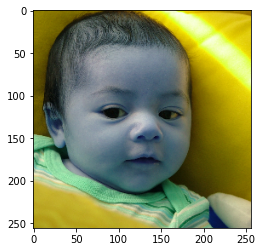

In [9]:
image_path  = os.path.join(opt["dataroot_npy"],"images.npy")
print(image_path)
images = np.load(image_path, mmap_mode='r')
print(images.shape)
image1 = images[0]
inMemImages = images[:100]
plt.imshow(inMemImages[0])

In [18]:
image1 = np.array(image1)
print(image1.shape)
print((image1.size))

(256, 256, 3)
196608


In [23]:
print(len(image1.reshape(image1.size,-1)))

196608


In [30]:
testImages = images[:100]
print(testImages.shape)
reshapedImages = testImages.reshape(testImages.shape[0], testImages[0].size)
print(reshapedImages.shape)

(100, 256, 256, 3)
(100, 196608)


In [36]:
pca = PCA(n_components=10)
d=pca.fit_transform(reshapedImages)

In [39]:
print(d.shape)

(100, 10)


In [ ]:
pca.inverse_transform